## Autor: Claudio Honorato Junior

Este trabalho faz parte da Monografia apresentada ao Departamento de Ciências de Computação do Instituto de Ciências Matemáticas e de Computação, Universidade de São Paulo - ICMC/USP, como parte dos requisitos para obtenção do título de Especialista em Inteligência Artificial e Big Data.

## Classificação de Objetos Celestes e Espectros Estelares com Perceptron 

Este trabalho propõe o uso de Redes Neurais Multicamadas (MLP) para a classificação de 
objetos astronômicos com base em dados espectroscópicos do Sloan Digital Sky Survey (SDSS). 
A pesquisa aborda três objetivos principais: (i) classificar objetos celestes em estrelas, galáxias 
e quasares; (ii) subclassificar estrelas conforme a classificação espectral de Harvard, com base 
na temperatura superficial. O modelo MLP foi comparado com algoritmos tradicionais como 
SVM, KNN, Regressão Logística, Random Forest e Naive-Bayes, entre outros, avaliando seu desempenho por 
meio de métricas como acurácia, precisão, recall e F1-score. A metodologia incluiu limpeza, 
normalização e seleção de features espectrais, além de técnicas de validação cruzada para 
garantir a robustez dos resultados. Os achados mostram que redes neurais profundas podem 
ser eficazes na análise de espectros astronômicos, oferecendo uma alternativa promissora 
para o tratamento de grandes volumes de dados no contexto da astrofísica moderna.

#### Neste notebook: (i) classificar objetos celestes em estrelas, galáxias e quasares;

## Classification of Celestial Objects and Stellar Spectra with Perceptron

This work proposes the use of Multilayer Neural Networks (MLP) for the classification of 
astronomical objects based on spectroscopic data from the Sloan Digital Sky Survey (SDSS). The 
research addresses three main objectives: (i) to classify celestial objects into stars, galaxies, 
and quasars; (ii) to subclassify stars according to the Harvard spectral classification, based on 
surface temperature. The MLP model was compared with traditional algorithms such as SVM, 
KNN, Logistic Regression, Random Forest, and Naive-Bayes, between others, evaluating its performance 
through metrics such as accuracy, precision, recall, and F1-score. The methodology included 
spectral cleaning, normalization, and feature selection, as well as cross-validation techniques 
to ensure the robustness of the results. The findings show that deep neural networks can be 
effective in the analysis of astronomical spectra, offering a promising alternative for the 
treatment of large volumes of data in the context of modern astrophysics.

#### In this notebook:  (i) to classify celestial objects into stars, galaxies, and quasars;


### NOTEBOOK DE TRATAMENTO E PREPARAÇÃO DOS DADOS
#### O objetivo deste notebook é treinar os modelos e comparar para decidir o melhor, bem como salvar e armazenar os parametros utilizados.

In [0]:
"""
Fluxo completo de tuning e treinamento em scikit‑learn:
• scaler dentro do Pipeline (ColumnTransformer)
• y codificado antes (LabelEncoder)
"""

# =========================================================
# 0. IMPORTS
# =========================================================
import os, time, joblib, numpy as np, pandas as pd
from datetime import datetime
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (f1_score, accuracy_score,
                             precision_score, recall_score)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.exceptions import UndefinedMetricWarning
import matplotlib.pyplot as plt

In [0]:
# Codigo para executar no DATABRICKS

# Definir caminhos no DBFS
base_path = "dbfs:/FileStore/classification/astronomical_objects/"
pasta_silver = f"{base_path}silver/balanceado" # f"{base_path}silver/tratado"
pasta_dataset_teste = f"{pasta_silver}/dataset_teste" 
#pasta_mdl = f"{pasta_silver}/modelos_tratado"
pasta_mdl = f"{pasta_silver}/modelos"
conjunto_de_teste = "objetos_estelares_teste"
arquivo_dados = "objetos_estelares_balanceado" # arquivo_dados = "espectros_estelares_tratado"

# Criar as pastas usando dbutils
try:
    dbutils.fs.mkdirs(pasta_silver)
    dbutils.fs.mkdirs(pasta_mdl)
    dbutils.fs.mkdirs(pasta_dataset_teste)
    print(f"Pastas criadas com sucesso em: {base_path}")
except Exception as e:
    print(f"Erro ao criar pastas: {e}")

# Verificar estrutura criada
print("\nEstrutura de pastas:")
print(f"Silver: {pasta_silver}")
print(f"Modelos (pasta_mdl): {pasta_mdl}")
print(f"Modelos (pasta_dataset_teste): {pasta_dataset_teste}")
print(f"Arquivos esperados: {arquivo_dados}, {conjunto_de_teste}")


Pastas criadas com sucesso em: dbfs:/FileStore/classification/astronomical_objects/

Estrutura de pastas:
Silver: dbfs:/FileStore/classification/astronomical_objects/silver/balanceado
Modelos (pasta_mdl): dbfs:/FileStore/classification/astronomical_objects/silver/balanceado/modelos
Modelos (pasta_dataset_teste): dbfs:/FileStore/classification/astronomical_objects/silver/balanceado/dataset_teste
Arquivos esperados: objetos_estelares_balanceado, objetos_estelares_teste


In [0]:
# ------------------
# Etapa 2: Leitura dos dados com spark
# ------------------
caminho_completo = pasta_silver + "/" + arquivo_dados
print(caminho_completo)

df = spark.read.parquet(caminho_completo)
df = df.limit(5000)

df_pd = df.toPandas()

dbfs:/FileStore/classification/astronomical_objects/silver/balanceado/objetos_estelares_balanceado


In [0]:
# ------------------
# Etapa 3: Preparar os dados
# ------------------
X = df_pd.drop("class", axis=1)           # Features
y = df_pd["class"]                        # Rótulo (classe)

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [0]:
print(X_train.shape[0])
print(X_test.shape[0])


3500
1500


In [0]:
# Separar conjunto de test para inferir em outro notebook
df_final_test = pd.concat([X_test, y_test], axis=1)

# Transformar em df spark
df_test = spark.createDataFrame(df_final_test)

In [0]:
caminho_completo = pasta_dataset_teste + "/" + conjunto_de_teste
print(caminho_completo)

# Salvando dados de teste separadamente
df_test.write.mode("overwrite").parquet(caminho_completo)

dbfs:/FileStore/classification/astronomical_objects/silver/balanceado/dataset_teste/objetos_estelares_teste


In [0]:
# =========================================================
# 2. PRÉ‑PROCESSAMENTO ÚNICO NO ALVO (LabelEncoder em y)
# =========================================================
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded  = le.transform(y_test)

INPUT_LAYER_SIZE  = X_train.shape[1]
OUTPUT_LAYER_SIZE = len(np.unique(y_train_encoded))   # se precisar na Spark/MLP

In [0]:
# # =========================================================
# # 1. CONSTANTES E HIPERPARÂMETROS
# # =========================================================
CV_FOLDS = 2
RANDOM_STATE = 42
SCORING_METRIC = "f1_weighted"
N_JOBS_PARALLEL = -1
PASTA_MODELOS = pasta_mdl

# =========================================================
# Grades de hiperparâmetros para RandomizedSearch / Halving
# — cada lista contém os valores que poderão ser sorteados —
# =========================================================

# ----------- LOGISTIC REGRESSION -------------------------
# C ............. Inverso da força de regularização L2/L1.
#                 Quanto maior, menos regularização (modelo “mais livre”).
# penalty ....... Tipo de regularização (L2 = Ridge, L1 = Lasso,
#                 elasticnet = mistura entre L1 e L2).
# l1_ratio ...... Proporção L1 na elasticnet (0 = só L2, 1 = só L1).
# class_weight .. 'balanced' ajusta pesos inversamente proporcionais
#                 às frequências das classes; None = sem ajuste.
LOGREG_C          = np.logspace(-3, 2, 6)          # 0.001 → 100
LOGREG_PENALTY    = ["l2", "l1", "elasticnet"]
LOGREG_L1_RATIO   = np.linspace(0.0, 1.0, 5)       # apenas p/ elasticnet
LOGREG_CLASS_WT   = ["balanced", None]
LOGREG_MAX_ITER = 10000

# ----------- DECISION TREE -------------------------------
# max_depth ...... Profundidade máxima da árvore (None = ilimitada).
# min_samples_leaf Nº mínimo de amostras para estar numa folha —
#                  evita folhas com poucos exemplos / overfitting.
# min_samples_split Nº mínimo p/ dividir um nó.
# class_weight .... Balanceamento de classes (idem acima).
DT_MAX_DEPTH      = [None, 10, 20, 40]
DT_MIN_SAMPLES_LF = [1, 2, 4]
DT_MIN_SAMPLES_SPL= [2, 5, 10]
DT_CLASS_WT       = ["balanced", None]

# ----------- RANDOM FOREST -------------------------------
# n_estimators .... Nº de árvores no ensemble.
# max_depth ....... Profundidade máxima de cada árvore.
# max_features .... Fração ou modo de seleção de variáveis em cada split
#                   ('sqrt' = √p, 0.3 = 30 % das features etc.).
# min_samples_leaf  Idem DecisionTree.
# class_weight .... Balanceamento.
RF_N_ESTIMATORS   = [200, 500, 800]
RF_MAX_DEPTH      = [None, 20, 40]
RF_MAX_FEATURES   = ["sqrt", 0.3, 0.5]
RF_MIN_SAMPLES_LF = [1, 2]
RF_CLASS_WT       = ["balanced", None]

# -------- GRADIENT BOOSTING (ou HistGradientBoosting) ----
# n_estimators .... Nº de árvores sequenciais.
# learning_rate ... Fator multiplicador de cada árvore (shrinkage).
# max_depth ....... Profundidade de cada árvore base.
# subsample ....... Fração de amostras sorteadas p/ cada árvore
#                   (<1.0 faz “stochastic gradient boosting”).
# class_weight .... Balanceamento.
GB_MAX_ITER         = [100, 200]
GB_LEARNING_RATE    = [0.05, 0.1]
GB_MAX_DEPTH        = [5, None]
GB_SUBSAMPLE        = [0.5, 0.7, 1.0]
GB_CLASS_WT         = ["balanced", None]
GB_L2_REG           = [0.0, 0.1]

# --------------------- MLP -------------------------------
# hidden_layer_sizes Tupla com o nº de neurônios em cada camada oculta
#                    (entrada/saída são inferidas automaticamente).
# alpha ............ Regularização L2 nos pesos (quanto maior, mais “suave”).
# learning_rate_init Taxa de aprendizagem inicial do otimizador Adam.
# batch_size ....... Nº de amostras por mini‑batch.
# early_stopping ... Faz split interno validação e para quando a loss pára
#                    de melhorar (evita overfitting e treino infinito).
# beta_1 / beta_2 .. Hiperparâmetros do Adam (momentum).
MLP_HIDDEN_LAYER_SIZES = [
    (256, 128, 64),  # mais profunda
    (128, 64, 32),
    (128, 64),
    (64, 32),
]

MLP_ALPHA = np.logspace(-6, -3, 4)  # menor regularização: [1e-6, 1e-5, 1e-4, 1e-3]
MLP_LR_INIT = [1e-4, 5e-4, 1e-3]  # taxa de aprendizado mais refinada
MLP_BATCH_SIZE = [64, 128]  # menor batch para aprendizado mais fino
MLP_EARLY_STOP = [True]  # mantém
MLP_BETA_1 = [0.9, 0.95]  # momentum do Adam
MLP_BETA_2 = [0.999]  # padrão
MLP_MAX_ITER = 10000  # mantém

param_dist_mlp = {
    "clf__hidden_layer_sizes": MLP_HIDDEN_LAYER_SIZES,
    "clf__alpha":              MLP_ALPHA,
    "clf__learning_rate_init": MLP_LR_INIT,
    "clf__batch_size":         MLP_BATCH_SIZE,
    "clf__early_stopping":     MLP_EARLY_STOP,
    "clf__beta_1":             MLP_BETA_1,
    "clf__beta_2":             MLP_BETA_2,
}


# # Naive Bayes
NB_VAR_SMOOTHING = np.logspace(-11, -7, 3)

# CONSTANTES – SVM
# (valores log/auto equilibrados para começar; ajuste se necessário)
SVM_C             = np.logspace(-2, 2, 5)    # 0.01 → 100
SVM_GAMMA         = ["scale", "auto"]        # só p/ kernel RBF
SVM_CLASS_WT      = ["balanced", None]       # lida com desbalanceamento

In [0]:
print(INPUT_LAYER_SIZE)
print(OUTPUT_LAYER_SIZE)

6
3


In [0]:
# Observações importantes
# LogisticRegression + elasticnet:

# solver="saga" é o único que aceita elasticnet no scikit-learn.

# Quando penalty != "elasticnet", o parâmetro l1_ratio é ignorado (não causa erro, mas também não influencia).

# class_weight:

# Modelos como árvore, random forest e regressão logística se beneficiam de class_weight='balanced' quando há desbalanceamento.

# MLP:

# early_stopping + batch_size + beta_1/beta_2 permitem um controle mais fino no treino.

# Dica:

# Ao usar RandomizedSearchCV, não é necessário se preocupar com combinações inválidas (ex: l1_ratio com penalty="l2"); o estimador apenas ignora.

In [0]:
# =========================================================
# 3. MODELOS + GRADES ATUALIZADAS (com base nas constantes)
# =========================================================

modelos_com_grid = {
    "logistic_regression": (
        LogisticRegression(
            max_iter=LOGREG_MAX_ITER,
            solver="saga",                     # necessário para L1 / elasticnet
            n_jobs=N_JOBS_PARALLEL,
            random_state=RANDOM_STATE
        ),
        {
            "clf__C":         LOGREG_C,
            "clf__penalty":   LOGREG_PENALTY,
            "clf__l1_ratio":  LOGREG_L1_RATIO,   # válido só se penalty="elasticnet"
            "clf__class_weight": LOGREG_CLASS_WT,
        },
    ),

    "decision_tree": (
        DecisionTreeClassifier(random_state=RANDOM_STATE),
        {
            "clf__max_depth":        DT_MAX_DEPTH,
            "clf__min_samples_leaf": DT_MIN_SAMPLES_LF,
            "clf__min_samples_split":DT_MIN_SAMPLES_SPL,
            "clf__class_weight":     DT_CLASS_WT,
        },
    ),

    "random_forest": (
        RandomForestClassifier(
            random_state=RANDOM_STATE,
            n_jobs=N_JOBS_PARALLEL
        ),
        {
            "clf__n_estimators":     RF_N_ESTIMATORS,
            "clf__max_depth":        RF_MAX_DEPTH,
            "clf__max_features":     RF_MAX_FEATURES,
            "clf__min_samples_leaf": RF_MIN_SAMPLES_LF,
            "clf__class_weight":     RF_CLASS_WT,
        },
    ),

    # "gradient_boosting": (
    #     GradientBoostingClassifier(random_state=RANDOM_STATE),
    #     {
    #         "clf__n_estimators":     GB_N_ESTIMATORS,
    #         "clf__learning_rate":    GB_LEARNING_RATE,
    #         "clf__max_depth":        GB_MAX_DEPTH,
    #         "clf__subsample":        GB_SUBSAMPLE,
    #     },
    # ),
    
    "hist_gradient_boosting": (
        HistGradientBoostingClassifier(random_state=RANDOM_STATE),
        {
            "clf__learning_rate":       GB_LEARNING_RATE,
            "clf__max_depth":           GB_MAX_DEPTH,
            "clf__max_iter":            GB_MAX_ITER,    # equivalente a n_estimators
            "clf__l2_regularization":   GB_L2_REG,
        },
    ),

    "naive_bayes": (
        GaussianNB(),
        {
            "clf__var_smoothing": NB_VAR_SMOOTHING,
        },
    ),

    "mlp": (
        MLPClassifier(
            max_iter=MLP_MAX_ITER,
            random_state=RANDOM_STATE
        ),
        {
            "clf__hidden_layer_sizes": MLP_HIDDEN_LAYER_SIZES,
            "clf__alpha":              MLP_ALPHA,
            "clf__learning_rate_init": MLP_LR_INIT,
            "clf__batch_size":         MLP_BATCH_SIZE,
            "clf__early_stopping":     MLP_EARLY_STOP,
            "clf__beta_1":             MLP_BETA_1,
            "clf__beta_2":             MLP_BETA_2,
        },
    ),
    
    "svm_rbf": (
        SVC(kernel="rbf", probability=False,   # probability=True = mais lento
            random_state=RANDOM_STATE),
        {
            "clf__C":            SVM_C,
            "clf__gamma":        SVM_GAMMA,
            "clf__class_weight": SVM_CLASS_WT,
        },
    ),
}


In [0]:
for nome, (est, grid) in modelos_com_grid.items():
    print("nome: ",nome)
    print("est: ",est)
    print("grid: ",grid)
    print("-------------------------")

nome:  logistic_regression
est:  LogisticRegression(max_iter=10000, n_jobs=-1, random_state=42, solver='saga')
grid:  {'clf__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]), 'clf__penalty': ['l2', 'l1', 'elasticnet'], 'clf__l1_ratio': array([0.  , 0.25, 0.5 , 0.75, 1.  ]), 'clf__class_weight': ['balanced', None]}
-------------------------
nome:  decision_tree
est:  DecisionTreeClassifier(random_state=42)
grid:  {'clf__max_depth': [None, 10, 20, 40], 'clf__min_samples_leaf': [1, 2, 4], 'clf__min_samples_split': [2, 5, 10], 'clf__class_weight': ['balanced', None]}
-------------------------
nome:  random_forest
est:  RandomForestClassifier(n_jobs=-1, random_state=42)
grid:  {'clf__n_estimators': [200, 500, 800], 'clf__max_depth': [None, 20, 40], 'clf__max_features': ['sqrt', 0.3, 0.5], 'clf__min_samples_leaf': [1, 2], 'clf__class_weight': ['balanced', None]}
-------------------------
nome:  hist_gradient_boosting
est:  HistGradientBoostingClassifier(random_state=42)
grid:  {'c

In [0]:
# =========================================================
# 4. CROSS‑VALIDAÇÃO + TREINO
# =========================================================
cv_obj   = StratifiedKFold(n_splits=CV_FOLDS,
                           shuffle=True, random_state=RANDOM_STATE)
                           
# ColumnTransformer aplica StandardScaler em TODAS as colunas numéricas
preprocess = ColumnTransformer(
    [("num", StandardScaler(), list(range(INPUT_LAYER_SIZE)))],
    remainder="passthrough",
    n_jobs=N_JOBS_PARALLEL,
)


[2025-07-14 19:33:25] Iniciando tuning: logistic_regression
Fitting 2 folds for each of 15 candidates, totalling 30 fits


/databricks/python/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[2025-07-14 19:34:02] Modelo salvo: /dbfs/FileStore/classification/astronomical_objects/silver/balanceado/modelos/logistic_regression_best.pkl
Tempo: 35.66s | F1_w: 0.9570 | F1_macro: 0.9468 | Acc: 0.9573 | Prec_w: 0.9571 | Rec_w: 0.9573
F1 por classe: [0.9664 0.8971 0.977 ]
Melhores parâmetros: {'clf__penalty': 'l1', 'clf__l1_ratio': np.float64(0.75), 'clf__class_weight': None, 'clf__C': np.float64(10.0)}


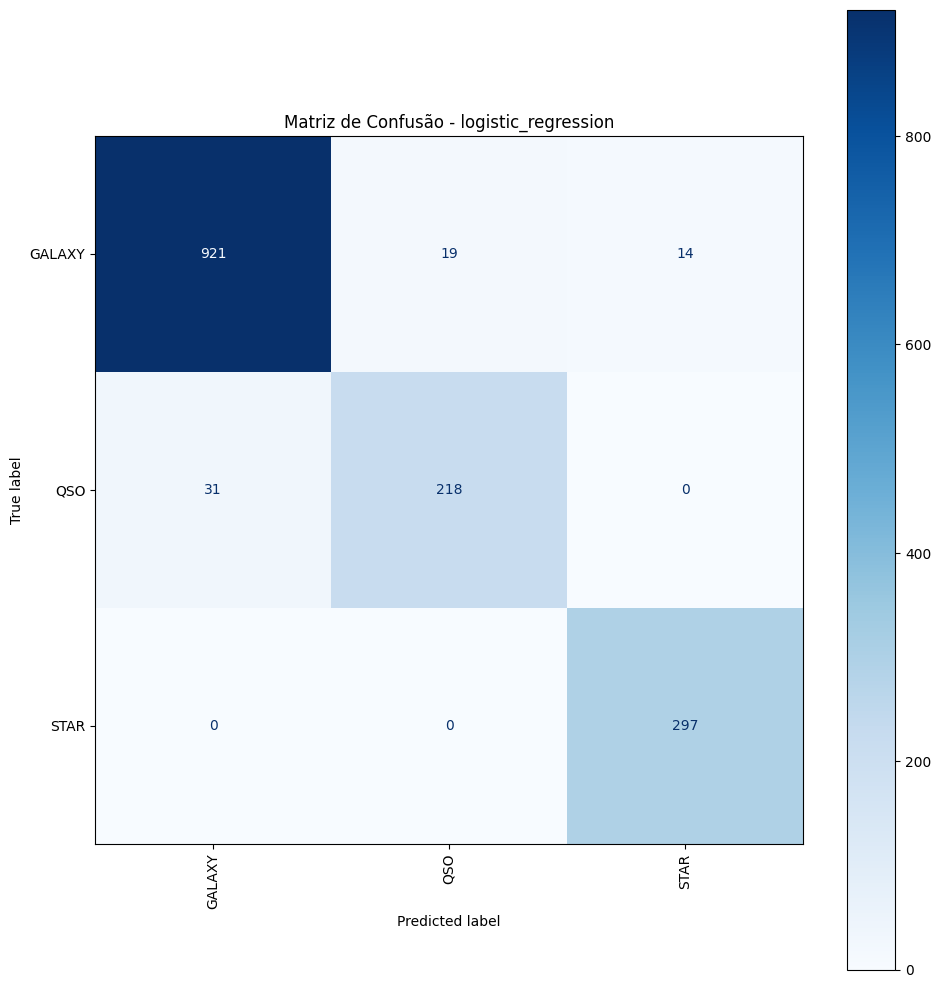


[2025-07-14 19:34:02] Iniciando tuning: decision_tree
Fitting 2 folds for each of 15 candidates, totalling 30 fits
[2025-07-14 19:34:18] Modelo salvo: /dbfs/FileStore/classification/astronomical_objects/silver/balanceado/modelos/decision_tree_best.pkl
Tempo: 14.36s | F1_w: 0.9640 | F1_macro: 0.9552 | Acc: 0.9640 | Prec_w: 0.9640 | Rec_w: 0.9640
F1 por classe: [0.9718 0.9073 0.9864]
Melhores parâmetros: {'clf__min_samples_split': 10, 'clf__min_samples_leaf': 2, 'clf__max_depth': 10, 'clf__class_weight': None}


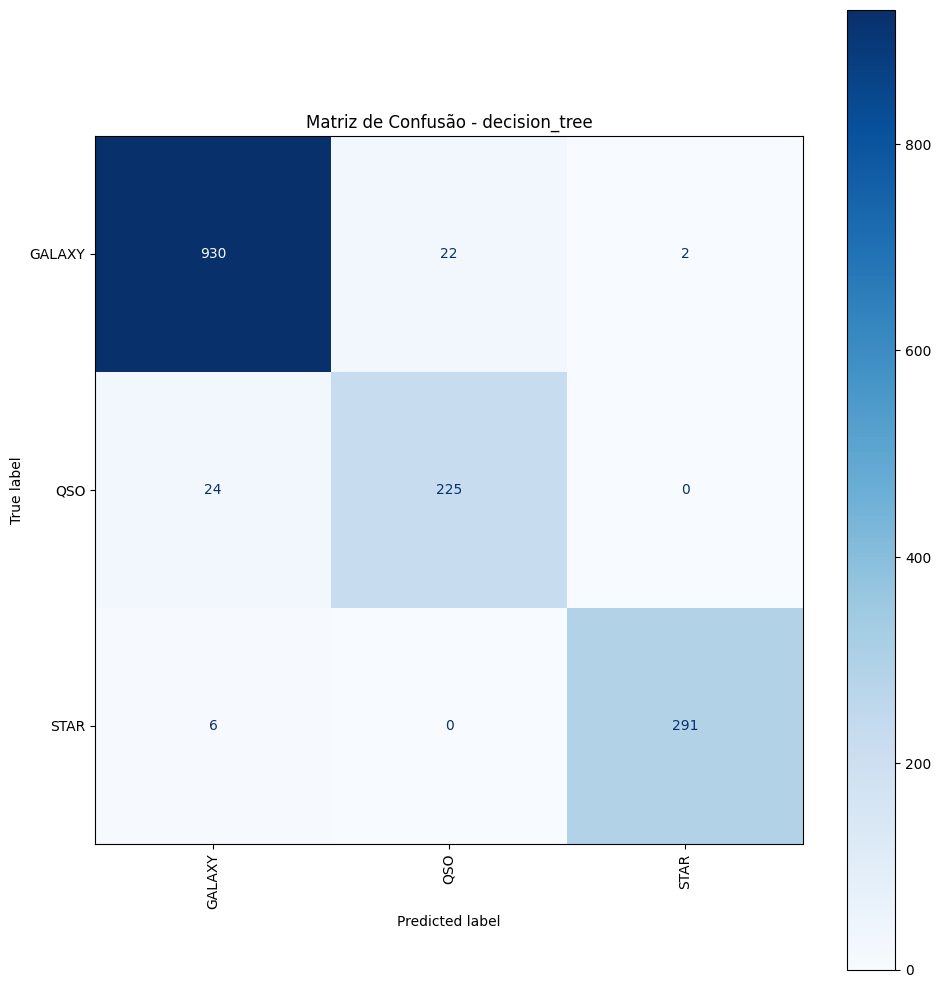


[2025-07-14 19:34:18] Iniciando tuning: random_forest
Fitting 2 folds for each of 15 candidates, totalling 30 fits
[2025-07-14 19:35:19] Modelo salvo: /dbfs/FileStore/classification/astronomical_objects/silver/balanceado/modelos/random_forest_best.pkl
Tempo: 58.11s | F1_w: 0.9746 | F1_macro: 0.9682 | Acc: 0.9747 | Prec_w: 0.9745 | Rec_w: 0.9747
F1 por classe: [0.9801 0.9312 0.9933]
Melhores parâmetros: {'clf__n_estimators': 500, 'clf__min_samples_leaf': 2, 'clf__max_features': 'sqrt', 'clf__max_depth': None, 'clf__class_weight': 'balanced'}


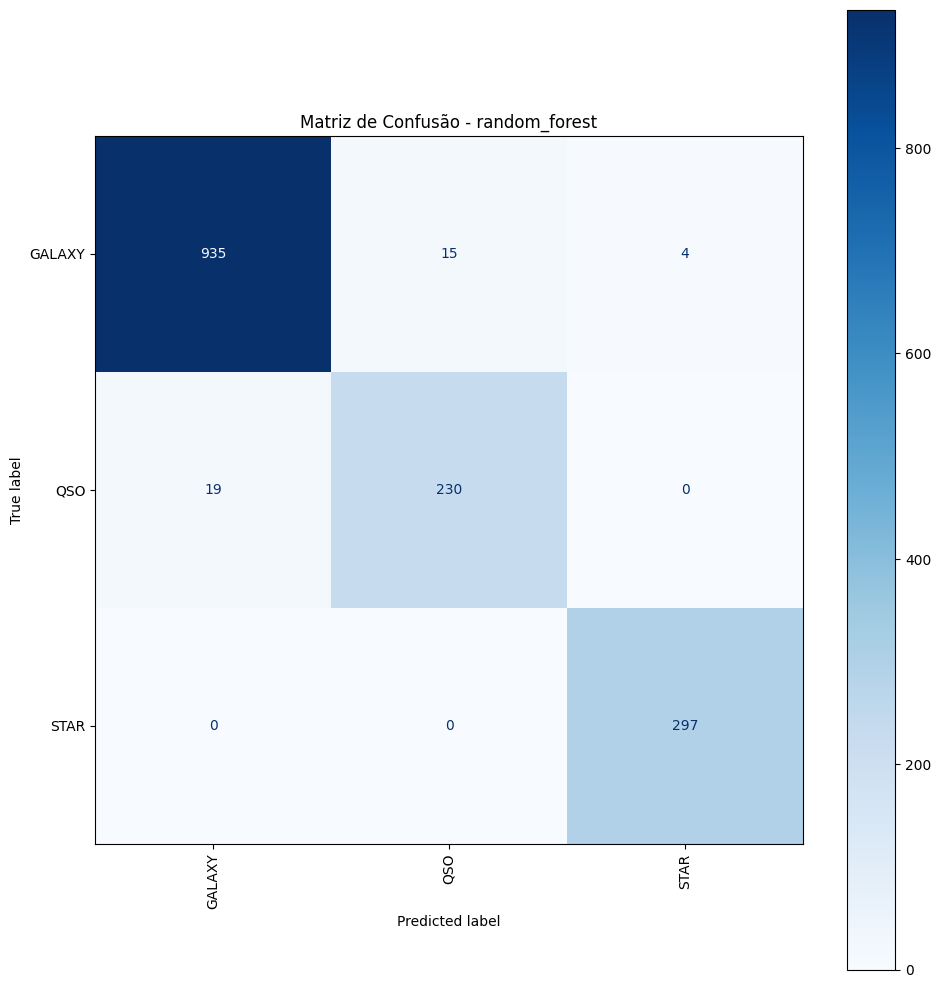


[2025-07-14 19:35:19] Iniciando tuning: hist_gradient_boosting
Fitting 2 folds for each of 15 candidates, totalling 30 fits
[2025-07-14 19:35:53] Modelo salvo: /dbfs/FileStore/classification/astronomical_objects/silver/balanceado/modelos/hist_gradient_boosting_best.pkl
Tempo: 32.18s | F1_w: 0.9745 | F1_macro: 0.9679 | Acc: 0.9747 | Prec_w: 0.9745 | Rec_w: 0.9747
F1 por classe: [0.9801 0.9287 0.995 ]
Melhores parâmetros: {'clf__max_iter': 200, 'clf__max_depth': None, 'clf__learning_rate': 0.05, 'clf__l2_regularization': 0.0}


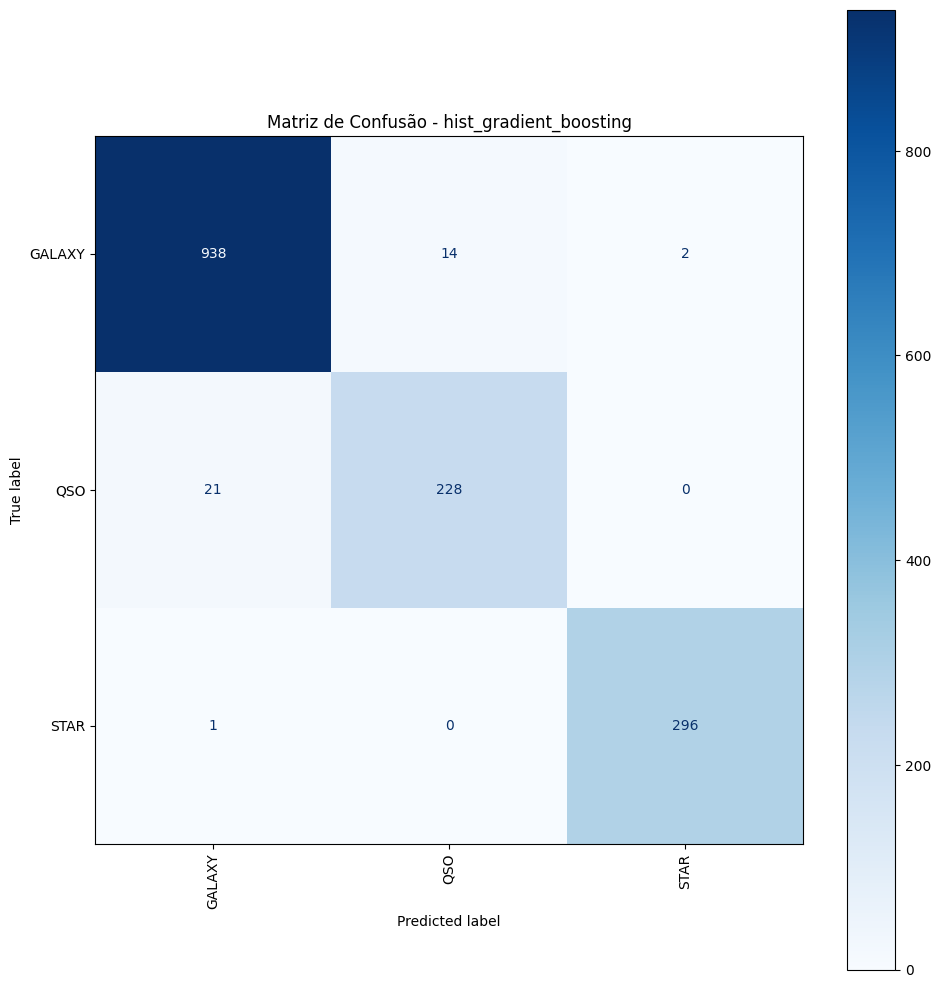


[2025-07-14 19:35:54] Iniciando tuning: naive_bayes


/databricks/python/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=15. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 3 candidates, totalling 6 fits
[2025-07-14 19:36:08] Modelo salvo: /dbfs/FileStore/classification/astronomical_objects/silver/balanceado/modelos/naive_bayes_best.pkl
Tempo: 12.78s | F1_w: 0.9451 | F1_macro: 0.9314 | Acc: 0.9447 | Prec_w: 0.9458 | Rec_w: 0.9447
F1 por classe: [0.9562 0.8431 0.995 ]
Melhores parâmetros: {'clf__var_smoothing': np.float64(1e-07)}


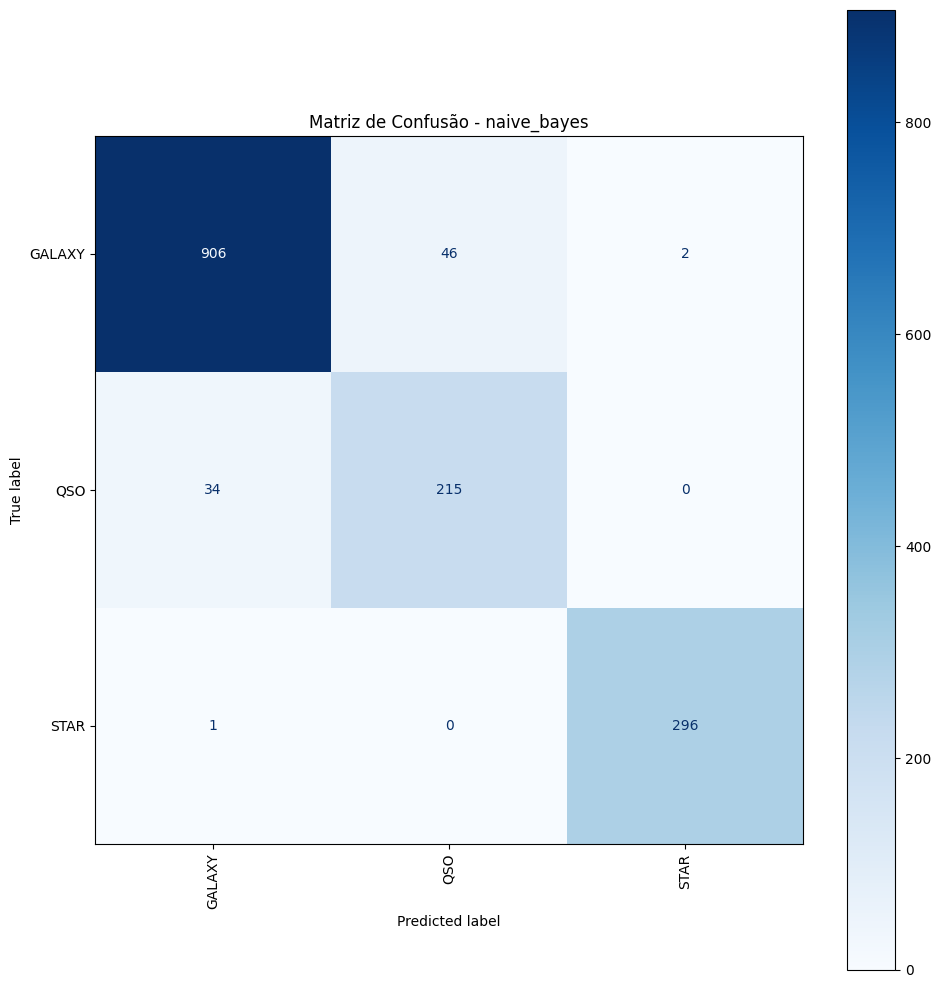


[2025-07-14 19:36:08] Iniciando tuning: mlp
Fitting 2 folds for each of 15 candidates, totalling 30 fits
[2025-07-14 19:36:47] Modelo salvo: /dbfs/FileStore/classification/astronomical_objects/silver/balanceado/modelos/mlp_best.pkl
Tempo: 37.70s | F1_w: 0.9638 | F1_macro: 0.9559 | Acc: 0.9640 | Prec_w: 0.9639 | Rec_w: 0.9640
F1 por classe: [0.9719 0.9278 0.968 ]
Melhores parâmetros: {'clf__learning_rate_init': 0.001, 'clf__hidden_layer_sizes': (128, 64, 32), 'clf__early_stopping': True, 'clf__beta_2': 0.999, 'clf__beta_1': 0.95, 'clf__batch_size': 64, 'clf__alpha': np.float64(0.0001)}


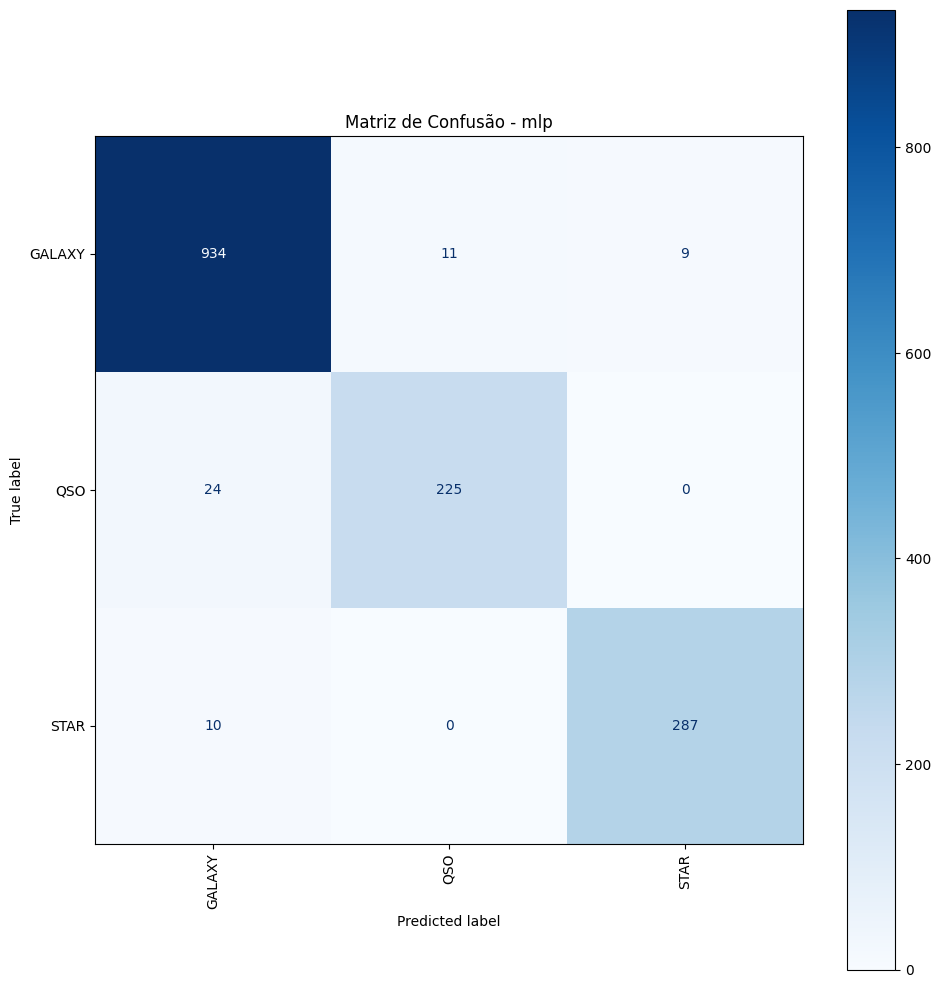


[2025-07-14 19:36:47] Iniciando tuning: svm_rbf
Fitting 2 folds for each of 15 candidates, totalling 30 fits
[2025-07-14 19:37:05] Modelo salvo: /dbfs/FileStore/classification/astronomical_objects/silver/balanceado/modelos/svm_rbf_best.pkl
Tempo: 16.13s | F1_w: 0.9592 | F1_macro: 0.9497 | Acc: 0.9593 | Prec_w: 0.9593 | Rec_w: 0.9593
F1 por classe: [0.9691 0.9196 0.9604]
Melhores parâmetros: {'clf__gamma': 'auto', 'clf__class_weight': None, 'clf__C': np.float64(10.0)}


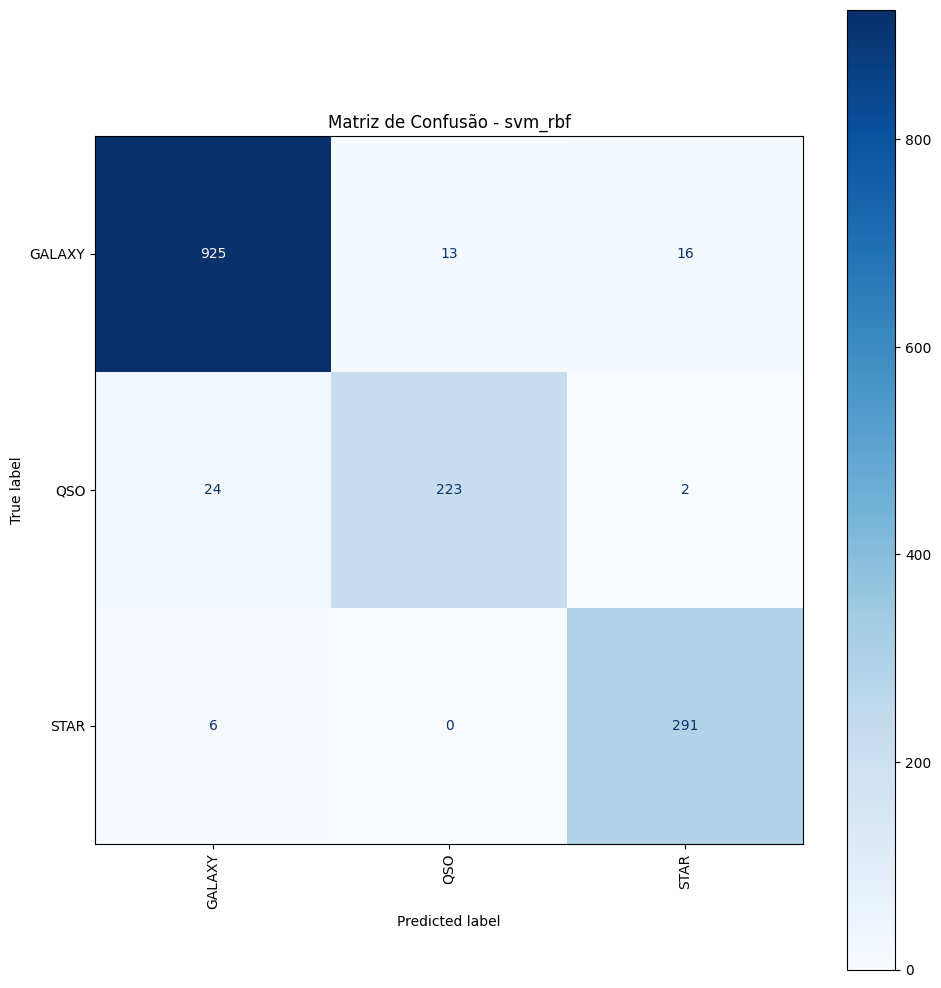

In [0]:
# Desativa mensagens do MLFlow e warnings
os.environ["MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR"] = "false"
os.environ["PYTHONWARNINGS"] = "ignore::UserWarning"

# Quantidade de combinações sorteadas por modelo
N_ITER_RANDOM = 15

# DEFINIR HEADER_PER_CLASS ANTES DO LOOP
# Garante que os rótulos sejam corretos para todos os modelos
class_names = le.inverse_transform(np.unique(y_test_encoded))
header_per_class = [f"f1_{cls}" for cls in class_names]
colunas_base = ["modelo", "f1_weighted", "f1_macro", "accuracy", "precision_w", "recall_w", "tempo_s"]
df_cols = colunas_base + header_per_class

# Armazena resultados
resultados_metricas = []

for nome, (est, grid) in modelos_com_grid.items():
    print(f"\n[{datetime.now():%Y-%m-%d %H:%M:%S}] Iniciando tuning: {nome}")
    inicio = time.time()
    
    pipeline = Pipeline([
        ("prep", preprocess),
        ("clf",  est)
    ])
    
    busca = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=grid,
        n_iter=N_ITER_RANDOM,
        scoring=SCORING_METRIC,
        cv=cv_obj,
        n_jobs=N_JOBS_PARALLEL,
        random_state=RANDOM_STATE,
        refit=True,
        verbose=3,
    )
    
    # Cópias para evitar problemas de imutabilidade
    X_train_writable = np.copy(X_train)
    y_train_encoded_writable = np.copy(y_train_encoded)
    X_test_writable = np.copy(X_test)
    y_test_encoded_writable = np.copy(y_test_encoded)
    
    busca.fit(X_train_writable, y_train_encoded_writable)
    duracao = time.time() - inicio
    
    # ---- Salva melhor modelo ----
    caminho_modelo = os.path.join(PASTA_MODELOS, f"{nome}_best.pkl").replace("dbfs:", "/dbfs")
    joblib.dump(busca.best_estimator_, caminho_modelo)
    
    # ---- Avaliação no teste ----
    y_pred = busca.predict(X_test_writable)
    f1_weighted = f1_score(y_test_encoded_writable, y_pred, average="weighted")
    f1_macro    = f1_score(y_test_encoded_writable, y_pred, average="macro")
    f1_per_cl   = f1_score(y_test_encoded_writable, y_pred, average=None)
    acc  = accuracy_score(y_test_encoded_writable, y_pred)
    prec = precision_score(y_test_encoded_writable, y_pred, average="weighted", zero_division=0)
    rec  = recall_score(y_test_encoded_writable, y_pred, average="weighted", zero_division=0)
    
    print(f"[{datetime.now():%Y-%m-%d %H:%M:%S}] Modelo salvo: {caminho_modelo}")
    print(f"Tempo: {duracao:.2f}s | "
          f"F1_w: {f1_weighted:.4f} | F1_macro: {f1_macro:.4f} | "
          f"Acc: {acc:.4f} | Prec_w: {prec:.4f} | Rec_w: {rec:.4f}")
    print("F1 por classe:", np.round(f1_per_cl, 4))
    print("Melhores parâmetros:", busca.best_params_)
    
    # ---- Adiciona resultado à lista ----
    # Garante que f1_per_cl tenha o mesmo número de elementos que header_per_class
    if len(f1_per_cl) != len(header_per_class):
        print(f"AVISO: F1 por classe tem {len(f1_per_cl)} elementos, esperado {len(header_per_class)}")
        # Preenche com zeros se necessário ou trunca
        f1_per_cl_padded = np.zeros(len(header_per_class))
        f1_per_cl_padded[:min(len(f1_per_cl), len(header_per_class))] = f1_per_cl[:len(header_per_class)]
        f1_per_cl = f1_per_cl_padded
    
    # Adiciona o resultado no dataframe resultados_metricas
    resultados_metricas.append(
        [nome, f1_weighted, f1_macro, acc, prec, rec, duracao] + list(f1_per_cl)
    )
    
    # ---- Matriz de confusão ----
    cm = confusion_matrix(y_test_encoded_writable, y_pred, labels=np.arange(len(class_names)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(ax=ax, cmap="Blues", xticks_rotation="vertical")
    plt.title(f"Matriz de Confusão - {nome}")
    plt.tight_layout()
    plt.show()

In [0]:
# ---- GERAÇÃO DO DATAFRAME FINAL COM TODAS AS MÉTRICAS ----
df_result = pd.DataFrame(resultados_metricas, columns=df_cols)

# Ordenar em ordem decrescente
df_result = df_result.sort_values("f1_weighted", ascending=False)

# Arredondar valores numéricos para 4 casas decimais
colunas_numericas = df_result.select_dtypes(include=[np.number]).columns
df_result[colunas_numericas] = df_result[colunas_numericas].round(4)  # coloque 2 se quiser duas casas

display(df_result)

modelo,f1_weighted,f1_macro,accuracy,precision_w,recall_w,tempo_s,f1_GALAXY,f1_QSO,f1_STAR
random_forest,0.9746,0.9682,0.9747,0.9745,0.9747,58.1117,0.9801,0.9312,0.9933
hist_gradient_boosting,0.9745,0.9679,0.9747,0.9745,0.9747,32.1759,0.9801,0.9287,0.995
decision_tree,0.964,0.9552,0.964,0.964,0.964,14.3564,0.9718,0.9073,0.9864
mlp,0.9638,0.9559,0.964,0.9639,0.964,37.6979,0.9719,0.9278,0.968
svm_rbf,0.9592,0.9497,0.9593,0.9593,0.9593,16.1335,0.9691,0.9196,0.9604
logistic_regression,0.957,0.9468,0.9573,0.9571,0.9573,35.6572,0.9664,0.8971,0.977
naive_bayes,0.9451,0.9314,0.9447,0.9458,0.9447,12.776,0.9562,0.8431,0.995
